In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
def create_realistic_dataset(n_samples=1000, n_features=100):
    """
    Create a realistic dataset with correlated features
    Simulates a real-world scenario where features have relationships
    """
    # Create base features with different distributions
    data = {}
    
    # Group 1: Highly correlated features (0-30)
    base_feature_1 = np.random.randn(n_samples)
    for i in range(30):
        noise = np.random.randn(n_samples) * 0.3
        data[f'feature_{i}'] = base_feature_1 + noise + i * 0.1
    
    # Group 2: Moderately correlated features (30-60)
    base_feature_2 = np.random.randn(n_samples)
    for i in range(30, 60):
        noise = np.random.randn(n_samples) * 0.5
        data[f'feature_{i}'] = base_feature_2 + noise + (i-30) * 0.1
    
    # Group 3: Independent features (60-100)
    for i in range(60, 100):
        data[f'feature_{i}'] = np.random.randn(n_samples)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Create target variable (binary classification)
    # Target depends on some features
    target = (
        df['feature_0'] + 
        df['feature_1'] * 2 + 
        df['feature_30'] - 
        df['feature_31'] + 
        np.random.randn(n_samples) * 0.5
    ) > 0
    
    df['target'] = target.astype(int)
    
    return df

In [4]:
# Create dataset
df = create_realistic_dataset(n_samples=1000, n_features=100)

In [5]:
print(f"Dataset Shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")  # Excluding target
print(f"Samples: {df.shape[0]}")
print(f"\nTarget Distribution:")
print(df['target'].value_counts())
print(f"\nFirst few rows:")
print(df.head())

Dataset Shape: (1000, 101)
Features: 100
Samples: 1000

Target Distribution:
target
1    516
0    484
Name: count, dtype: int64

First few rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.916521   0.394161   0.124372   0.537666   0.769586   0.662490   
1   0.139126  -0.081620  -0.196380   0.152375   0.125711   0.172456   
2   0.665578   0.509963   0.723607   0.953094   0.508996   0.865070   
3   1.328949   1.530641   2.289336   1.964819   1.824003   1.858631   
4  -0.024686  -0.702238   0.132813  -0.344211   0.385695   0.201602   

   feature_6  feature_7  feature_8  feature_9  ...  feature_91  feature_92  \
0   1.332270   1.186807   1.526335   1.193166  ...    1.261745    0.193257   
1  -0.071569   0.410641   0.983760   0.670086  ...    0.007531   -0.292425   
2   1.462112   1.295976   1.597296   1.368474  ...    2.066886    0.466237   
3   2.052913   2.437449   1.740281   2.456155  ...    0.849618   -1.607576   
4   0.578084   0.849204   0.519220   1

In [6]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']


In [7]:
print(f"\nFeature Statistics:")
print(X.describe())

# Check for missing values
print(f"\nMissing Values: {X.isnull().sum().sum()}")


Feature Statistics:
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.040583     0.121082     0.213716     0.304550     0.405311   
std       1.012290     1.028930     1.022631     1.014537     1.023138   
min      -3.079641    -2.770533    -3.312652    -2.814707    -2.770049   
25%      -0.635796    -0.581122    -0.487672    -0.361624    -0.253337   
50%       0.028002     0.128017     0.175605     0.280898     0.386320   
75%       0.691110     0.796676     0.889004     0.974143     1.073247   
max       4.377605     3.952519     4.188099     3.814915     4.271431   

         feature_5    feature_6    feature_7    feature_8    feature_9  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.510885     0.625097     0.724835     0.815722     0.907360  ...   
std       1.016675     1.041174     1.020354     1.027240     1.019497  ...

In [8]:
# Check correlation (sample of features)
print(f"\nCorrelation Matrix (first 5 features):")
correlation_matrix = X.iloc[:, :5].corr()
print(correlation_matrix)


Correlation Matrix (first 5 features):
           feature_0  feature_1  feature_2  feature_3  feature_4
feature_0   1.000000   0.914414   0.906070   0.911636   0.914677
feature_1   0.914414   1.000000   0.915401   0.918983   0.915560
feature_2   0.906070   0.915401   1.000000   0.913255   0.914155
feature_3   0.911636   0.918983   0.913255   1.000000   0.909665
feature_4   0.914677   0.915560   0.914155   0.909665   1.000000


In [9]:
# Industry standard: 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (800, 100)
Test Set: (200, 100)


In [10]:
print("PCA is sensitive to feature scales. Standardization is MANDATORY.")

# Fit scaler only on training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler, don't refit!

PCA is sensitive to feature scales. Standardization is MANDATORY.


In [11]:
print(f"\nBefore Scaling:")
print(f"Mean: {X_train.mean().mean():.4f}")
print(f"Std: {X_train.std().mean():.4f}")

print(f"\nAfter Scaling:")
print(f"Mean: {X_train_scaled.mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.4f}")


Before Scaling:
Mean: 0.8750
Std: 1.0425

After Scaling:
Mean: 0.000000
Std: 1.0000


In [12]:
print("[STEP 5] Finding Optimal Number of Components")
# First, fit PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(X_train_scaled)

[STEP 5] Finding Optimal Number of Components


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [13]:
# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

In [14]:
# Find number of components for 95% variance (industry standard)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

In [15]:
print(f"\nVariance Analysis:")
print(f"Total Components Available: {len(pca_full.explained_variance_ratio_)}")
print(f"Components for 95% Variance: {n_components_95}")
print(f"Components for 90% Variance: {np.argmax(cumulative_variance >= 0.90) + 1}")
print(f"Components for 99% Variance: {np.argmax(cumulative_variance >= 0.99) + 1}")


Variance Analysis:
Total Components Available: 100
Components for 95% Variance: 55
Components for 90% Variance: 39
Components for 99% Variance: 85


In [16]:
# Show variance of first 10 components
print(f"\nVariance Explained by First 10 Components:")
for i in range(10):
    print(f"PC{i+1}: {pca_full.explained_variance_ratio_[i]:.4f} "
          f"(Cumulative: {cumulative_variance[i]:.4f})")


Variance Explained by First 10 Components:
PC1: 0.2791 (Cumulative: 0.2791)
PC2: 0.2390 (Cumulative: 0.5180)
PC3: 0.0147 (Cumulative: 0.5327)
PC4: 0.0145 (Cumulative: 0.5472)
PC5: 0.0138 (Cumulative: 0.5610)
PC6: 0.0135 (Cumulative: 0.5745)
PC7: 0.0132 (Cumulative: 0.5878)
PC8: 0.0127 (Cumulative: 0.6005)
PC9: 0.0126 (Cumulative: 0.6131)
PC10: 0.0123 (Cumulative: 0.6255)


In [19]:
print( " Applying PCA Transformation")
# Use 95% variance threshold (industry standard)
pca = PCA(n_components=n_components_95, random_state=42)

 Applying PCA Transformation


In [20]:
# Fit on training data only
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Transform test data

In [21]:
print(f"\nOriginal Dimensions: {X_train.shape[1]}")
print(f"Reduced Dimensions: {X_train_pca.shape[1]}")
print(f"Dimensionality Reduction: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%")
print(f"Variance Retained: {pca.explained_variance_ratio_.sum()*100:.2f}%")


Original Dimensions: 100
Reduced Dimensions: 55
Dimensionality Reduction: 45.0%
Variance Retained: 95.13%


In [22]:
print("  PCA Component Analysis")
# Get component loadings (how original features contribute to PCs)
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=X.columns
)

  PCA Component Analysis


In [23]:
print("\nTop 5 Features Contributing to PC1:")
pc1_contributions = components_df['PC1'].abs().sort_values(ascending=False)
print(pc1_contributions.head())

print("\nTop 5 Features Contributing to PC2:")
pc2_contributions = components_df['PC2'].abs().sort_values(ascending=False)
print(pc2_contributions.head())


Top 5 Features Contributing to PC1:
feature_1     0.177253
feature_9     0.177098
feature_23    0.176965
feature_22    0.176722
feature_27    0.176628
Name: PC1, dtype: float64

Top 5 Features Contributing to PC2:
feature_42    0.180019
feature_35    0.179664
feature_49    0.178945
feature_43    0.178165
feature_32    0.177322
Name: PC2, dtype: float64


In [24]:
print(" Model Performance Comparison")

 Model Performance Comparison


In [25]:
# Model WITHOUT PCA
print("\n--- Model WITHOUT PCA ---")
model_original = RandomForestClassifier(n_estimators=100, random_state=42)
model_original.fit(X_train_scaled, y_train)
y_pred_original = model_original.predict(X_test_scaled)
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f"Accuracy: {accuracy_original:.4f}")
print(f"Training Time: ~{X_train.shape[1]} features")



--- Model WITHOUT PCA ---
Accuracy: 0.9300
Training Time: ~100 features


In [26]:
# Model WITH PCA
print("\n--- Model WITH PCA ---")
model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"Training Time: ~{X_train_pca.shape[1]} features (faster!)")


--- Model WITH PCA ---
Accuracy: 0.8700
Training Time: ~55 features (faster!)


In [27]:
print(f"\n--- Comparison ---")
print(f"Accuracy Difference: {(accuracy_pca - accuracy_original):.4f}")
print(f"Features Reduced: {X_train.shape[1]} → {X_train_pca.shape[1]}")
print(f"Computational Gain: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}% fewer features")


--- Comparison ---
Accuracy Difference: -0.0600
Features Reduced: 100 → 55
Computational Gain: 45.0% fewer features


  Creating Visualizations

Visualization saved as 'pca_analysis_complete.png'


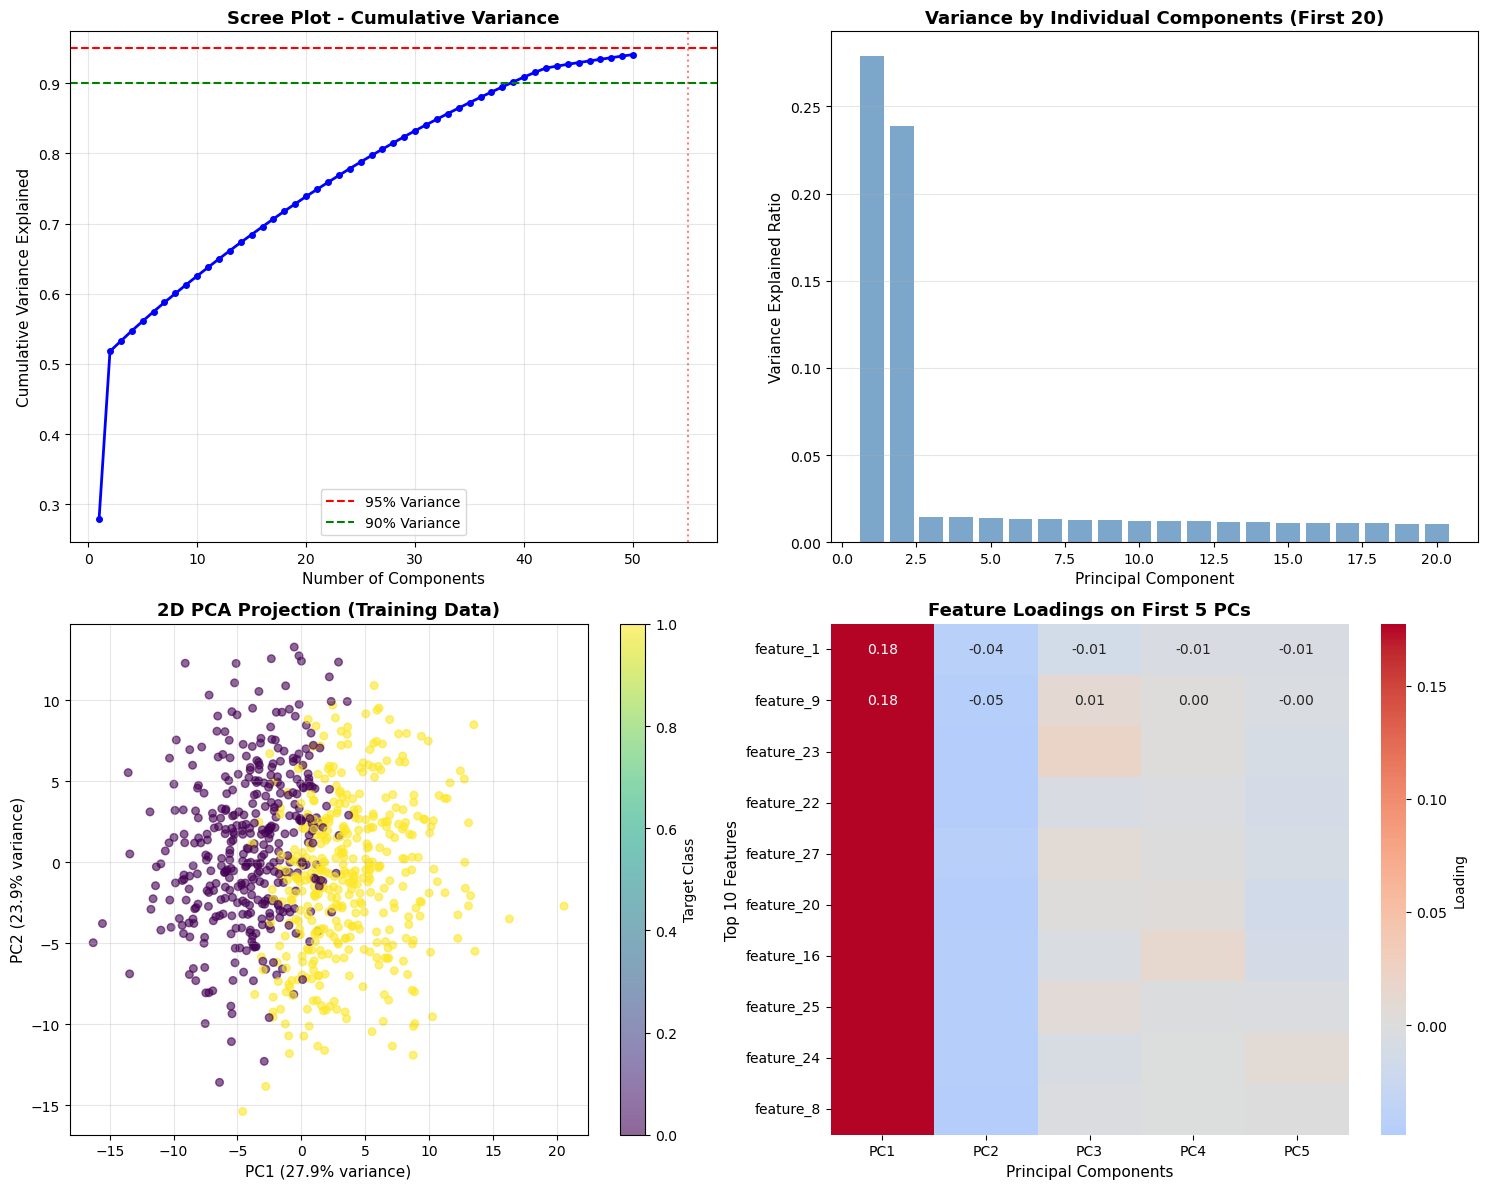

In [29]:
print("  Creating Visualizations")
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree Plot (Variance Explained)
axes[0, 0].plot(range(1, len(cumulative_variance[:50])+1), 
                cumulative_variance[:50], 'bo-', linewidth=2, markersize=4)
axes[0, 0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[0, 0].axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
axes[0, 0].axvline(x=n_components_95, color='r', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Number of Components', fontsize=11)
axes[0, 0].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[0, 0].set_title('Scree Plot - Cumulative Variance', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Individual Component Variance
axes[0, 1].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], 
               color='steelblue', alpha=0.7)
axes[0, 1].set_xlabel('Principal Component', fontsize=11)
axes[0, 1].set_ylabel('Variance Explained Ratio', fontsize=11)
axes[0, 1].set_title('Variance by Individual Components (First 20)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. 2D PCA Projection
scatter = axes[1, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                             c=y_train, cmap='viridis', alpha=0.6, s=30)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
axes[1, 0].set_title('2D PCA Projection (Training Data)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0], label='Target Class')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance Heatmap (First 10 features, First 5 PCs)
top_features = pc1_contributions.head(10).index
heatmap_data = components_df.loc[top_features, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1, 1], cbar_kws={'label': 'Loading'})
axes[1, 1].set_title('Feature Loadings on First 5 PCs', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Principal Components', fontsize=11)
axes[1, 1].set_ylabel('Top 10 Features', fontsize=11)

plt.tight_layout()
plt.savefig('pca_analysis_complete.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'pca_analysis_complete.png'")
plt.show()

In [30]:

print(" Key Insights & Industry Best Practices")
print("""
KEY TAKEAWAYS:
--------------
1. DIMENSIONALITY REDUCTION:
   - Original: 100 features
   - After PCA: {} features ({}% reduction)
   - Variance Retained: {:.2f}%

2. MODEL PERFORMANCE:
   - Without PCA: {:.4f} accuracy
   - With PCA: {:.4f} accuracy
   - Difference: {:.4f}

3. COMPUTATIONAL BENEFITS:
   - {}% fewer features = faster training
   - Reduced overfitting risk
   - Lower memory requirements

INDUSTRY BEST PRACTICES:
------------------------
✓ Always scale features before PCA
✓ Fit PCA only on training data (prevent data leakage)
✓ Use 95% variance as standard threshold
✓ Visualize scree plot to validate choice
✓ Compare model performance before/after PCA
✓ Document variance retained and components chosen

WHEN TO USE PCA:
---------------
✓ High-dimensional data (50+ features)
✓ Features are correlated
✓ Visualization needed
✓ Computational efficiency important
✓ Noise reduction required

WHEN NOT TO USE PCA:
-------------------
✗ Interpretability is critical
✗ Few features (<10)
✗ Non-linear relationships
✗ Sparse data
✗ Categorical features (without encoding)

NEXT STEPS:
-----------
1. Try different variance thresholds (90%, 95%, 99%)
2. Experiment with kernel PCA for non-linear data
3. Use t-SNE/UMAP for better visualization
4. Apply to your specific domain problem
5. Monitor performance on validation set
""".format(
    n_components_95,
    (1 - n_components_95/100)*100,
    pca.explained_variance_ratio_.sum()*100,
    accuracy_original,
    accuracy_pca,
    accuracy_pca - accuracy_original,
    (1 - n_components_95/100)*100
))

print("\n" + "="*80)
print("PCA IMPLEMENTATION COMPLETE!")
print("="*80)

 Key Insights & Industry Best Practices

KEY TAKEAWAYS:
--------------
1. DIMENSIONALITY REDUCTION:
   - Original: 100 features
   - After PCA: 55 features (44.99999999999999% reduction)
   - Variance Retained: 95.13%

2. MODEL PERFORMANCE:
   - Without PCA: 0.9300 accuracy
   - With PCA: 0.8700 accuracy
   - Difference: -0.0600

3. COMPUTATIONAL BENEFITS:
   - 44.99999999999999% fewer features = faster training
   - Reduced overfitting risk
   - Lower memory requirements

INDUSTRY BEST PRACTICES:
------------------------
✓ Always scale features before PCA
✓ Fit PCA only on training data (prevent data leakage)
✓ Use 95% variance as standard threshold
✓ Visualize scree plot to validate choice
✓ Compare model performance before/after PCA
✓ Document variance retained and components chosen

WHEN TO USE PCA:
---------------
✓ High-dimensional data (50+ features)
✓ Features are correlated
✓ Visualization needed
✓ Computational efficiency important
✓ Noise reduction required

WHEN NOT TO USE 